In [3]:
import pandas as pd
import random
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

%config InlineBackend.figure_format = 'retina'

In [4]:
# Download the dataset once
if not os.path.exists('fakenet_dataset'):
    !aws s3 cp s3://danylo-ucla/fakenet_dataset.zip ./
    !unzip fakenet_dataset.zip >/dev/null

In [5]:
!tree -L 2 fakenet_dataset

fakenet_dataset
├── score
│   ├── images
│   └── metadata.csv
└── train
    ├── images
    └── metadata.csv

4 directories, 2 files


## Methodology

* Firstly, try resnet and inception to see which one to use for transfer learning. Result shows that resnet works better.
* Secondly, try base models from single, paired, and paired and captioned dataset, to determine which data structure to use. The result shows that paired and captioned dataset has the best effect, so we use it for hyperparameter tuning.
  * For paired and captioned dataset, the transfomer used is BERT.
* Use hyperparameter tuning to find the best model for paired and captioned dataset. In addition to the pretrained resnet and BERT model, I added more dense layers to the top of it before the final classification. The best model is picked based on binary accuracy.
* Last step is fine tuning, where I only increased the number of epochs.
* New data generation methods for paired and captioned dataset are created for this assignment.

## Training Images and Metadata

In [6]:
train_metadata = pd.read_csv('fakenet_dataset/train/metadata.csv')

In [7]:
train_metadata.head()

file_name_training                   file_name_generated  \
0  ffd603965b2eb89bfa6e7bda19c903f9.jpg  d70026e562baeb2976d33ea72bbe2af2.jpg   
1  c5e15bda1013a6a8c28b87d23aa94767.jpg  41c055de712d74957659ab5d901c4212.jpg   
2  517547ba7695808a52ecd2e2f4b6faf7.jpg  aab1106eb9793b08b665902c74c8e0cf.jpg   
3  c3ff13909de96ed069fb2769800ea4b9.jpg  0658524e5dc4058fe7ceff0a72dbda18.jpg   
4  2b5c6c916a7110287f7193081906cc5e.jpg  8546adea5c43ea5e517abfa5208aa10d.jpg   

                                             caption  
0  a toilet with a green and white door and green...  
1  An older couple embracing each other next to a...  
2  A square glazed doughnut, and a chocolate doug...  
3   A large bathroom with tiled floor and big mirror  
4     A man riding a snowboard down a conveyor belt.

In [8]:
random.seed(43)

([], [])

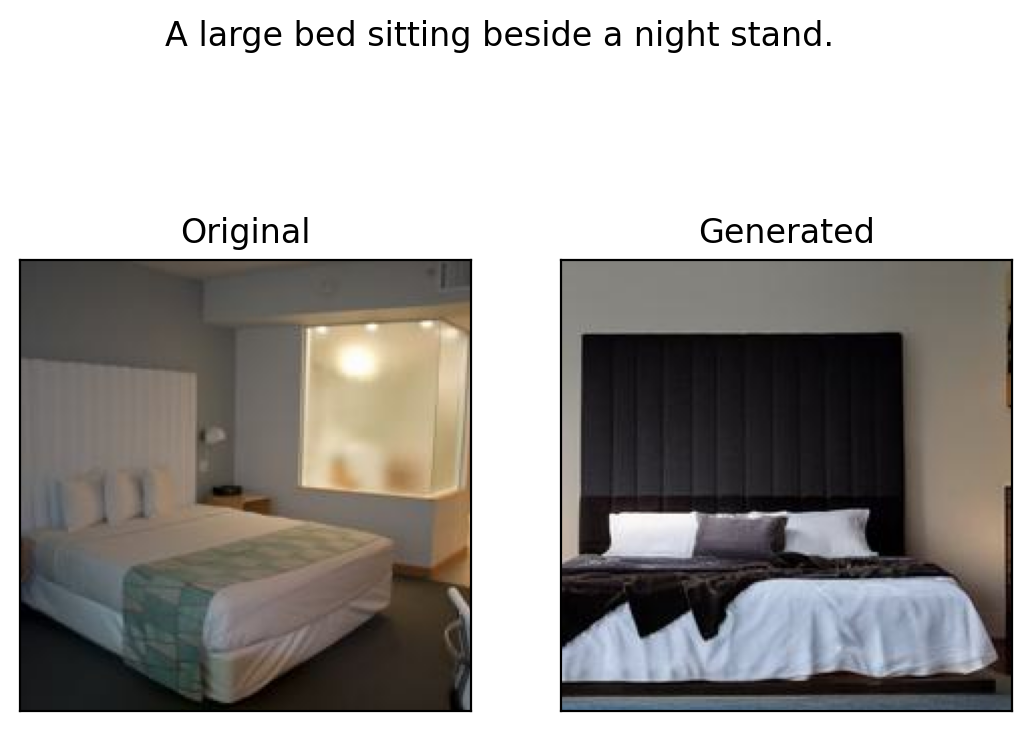

In [9]:
i = random.randint(0, train_metadata.shape[0])

file_name_training = train_metadata['file_name_training'].iloc[i]
file_name_generated = train_metadata['file_name_generated'].iloc[i]
caption = train_metadata['caption'].iloc[i]

plt.suptitle(caption)

plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_training}'))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.title('Generated')
plt.imshow(Image.open(f'fakenet_dataset/train/images/{file_name_generated}'))
plt.xticks([])
plt.yticks([])

## Training metadata split

In [10]:
train_ratio = 0.7
val_ratio = 0.15

# Determine the number of samples for each set
total_samples = train_metadata.shape[0]

num_train = int(train_ratio * total_samples)
num_val = int(val_ratio * total_samples)

train_md = train_metadata.iloc[:num_train]
val_md = train_metadata.iloc[num_train:num_train + num_val]
test_md = train_metadata.iloc[num_train + num_val:]

## Score Images and Metadata

In [11]:
score_metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
score_metadata

file_name_a  \
0     7ad84509c9b0226bc0288537a8ab22ae.jpg   
1     a4a39968e428b3c82257e25920e3adeb.jpg   
2     38ffec577b2c097f3a3403ae6c6638b8.jpg   
3     07ecbbbc269ba1bd2d5b792f9abea0ed.jpg   
4     10c585ad69ed895ac1a3b58d5dfb256a.jpg   
...                                    ...   
2811  1541d399a4be2e0c85ef061e6bddb60c.jpg   
2812  d1bc62f2b725409f46421219f16383df.jpg   
2813  7015aa30ddb1d1605c6822d2856e98db.jpg   
2814  3b76a717ad707699851465a0680f5798.jpg   
2815  048699161f7cd04b8dd6ecb601fcbf17.jpg   

                               file_name_b  \
0     798d20e113a6bde4525336ce66a84a69.jpg   
1     2d6c056b045062c97450a29dd83d8c63.jpg   
2     050d2c637cbfa509f9a0072d6ca422b5.jpg   
3     23cbc59d33f061d2930f27c641a01807.jpg   
4     7bbe5ae59f098437099f5ba093c2b38b.jpg   
...                                    ...   
2811  15e819f3f3ede6e2e20170d71185031d.jpg   
2812  06f2ad1c20ed610523d677e3cbb8fed6.jpg   
2813  846bd374ab91c40386fa48c1f5fdef78.jpg   
2814  f5a5c27c396aae7142805befc710f9ac.jpg   
2815  168fa67e8614b1008a084763049cf865.jpg   

                                                caption  
0     A couple of motorcycles parked next to each ot...  
1     A vase with a bird on it and a matching winegl...  
2                   a man that is surfing on some water  
3     A crowd of young people sanding on a snow cove...  
4     A kitchen with a refrigerator, counter and was...  
...                                                 ...  
2811      a close up of a person wearing a suit and tie  
2812  Zebras eat from a trough set up in their zoo e...  
2813       A group of people on a field with a Frisbee.  
2814  A boy sitting at a table eating food with food...  
2815  A man riding a snowboard down a snow covered s...  

[2816 rows x 3 columns]

## Creating Tensorflow Dataset (Single Image, Labeled Segment)

In [29]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled_single(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            training_path = 'fakenet_dataset/train/images/' + row['file_name_training']
            generated_path = 'fakenet_dataset/train/images/' + row['file_name_generated']

            training_np = np.array(Image.open(training_path)).astype(np.float32)
            generated_np = np.array(Image.open(generated_path)).astype(np.float32)

            model_input = training_np
            model_output = (1,)
            yield (model_input, model_output)

            model_input = generated_np
            model_output = (0,)
            yield (model_input, model_output)
    return generator


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled_single(metadata: pd.DataFrame) -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore
    model_output = tf.TensorSpec(shape=(1,), dtype=tf.int32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled_single(metadata), 
        output_signature=dataset_signature
    )

    return dataset


In [30]:
# train_single_dataset = build_dataset_labeled_single(train_metadata)
# model_input, model_output = next(iter(train_single_dataset))
# display(model_input.shape, model_output.shape)

In [19]:
# train_single_dataset = train_single_dataset.batch(16)
# model_input, model_output = next(iter(train_single_dataset))
# display(model_input.shape, model_output.shape)

In [37]:
# train_ratio = 0.7
# val_ratio = 0.15

# # Determine the number of samples for each set
# total_samples = train_single_dataset.reduce(0, lambda x, _: x + 1).numpy()

# num_train = int(train_ratio * total_samples)
# num_val = int(val_ratio * total_samples)

# # Create train, validation, and test datasets
# train_single, val_single, test_single = (
#     train_single_dataset.take(num_train),
#     train_single_dataset.skip(num_train).take(num_val),
#     train_single_dataset.skip(num_train + num_val),
# )


## Data split

In [31]:
train_single = build_dataset_labeled_single(train_md)
val_single = build_dataset_labeled_single(val_md)
test_single = build_dataset_labeled_single(test_md)

In [32]:
train_single = train_single.batch(16)

val_single = val_single.batch(16)
test_single = test_single.batch(16)

In [34]:
train_X, train_y = next(iter(train_single))
val_X, val_y = next(iter(val_single))
test_X, test_y = next(iter(test_single))

In [35]:
display(train_X.shape, train_y.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [36]:
display(val_X.shape, val_y.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [43]:
display(test_X.shape, test_y.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

### get_binary_accuracy

In [10]:
def get_binary_accuracy(train_x, train_y, model):  
    binary_accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

    train_y_pred = model.predict(train_x)

# Update the metric with your data
    binary_accuracy.update_state(train_y, train_y_pred)


    print(binary_accuracy.result().numpy())

# Single image Modeling - don't spend too much time, use base model to compare paired

## Tranfer learning

### resnet

In [25]:
resnet = tf.keras.applications.ResNet50(
include_top=False,
input_shape=(224, 224, 3),
weights='imagenet')

resnet.trainable = False

94781440/94765736 [==============================] - 2s 0us/step


In [37]:
model = tf.keras.models.Sequential([
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    'sgd', 
    'binary_crossentropy', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
        ]
    )

model.fit(train_single,
         validation_data=val_single)

986/986 [==============================] - 124s 120ms/step - loss: 11.5149 - binary_accuracy: 0.8110 - val_loss: 14.6088 - val_binary_accuracy: 0.8091


In [26]:
# get_binary_accuracy(train_X, train_y, model)

# get_binary_accuracy(val_X, val_y, model)

# get_binary_accuracy(test_X, test_y, model)

In [38]:
train_single_result = model.evaluate(train_single)

print('loss:', train_single_result[0], 'binary accuracy:', train_single_result[1])

val_single_result = model.evaluate(val_single)

print('loss:', val_single_result[0], 'binary accuracy:', val_single_result[1])

test_single_result = model.evaluate(test_single)

print('loss:', test_single_result[0], 'binary accuracy:', test_single_result[1])

986/986 [==============================] - 71s 72ms/step - loss: 8.8223 - binary_accuracy: 0.8510
loss: 8.822271347045898 binary accuracy: 0.8510084748268127
212/212 [==============================] - 15s 72ms/step - loss: 14.6088 - binary_accuracy: 0.8091
loss: 14.608837127685547 binary accuracy: 0.8090586066246033
212/212 [==============================] - 23s 109ms/step - loss: 14.9994 - binary_accuracy: 0.8012
loss: 14.999370574951172 binary accuracy: 0.8011834025382996


### Inception

* Worse result. Stick with resnet

In [49]:
inception = tf.keras.applications.InceptionV3(
    weights="imagenet",  
    input_shape=(224, 224, 3),
    include_top=False,
)  


inception.trainable = False

model = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    'sgd', 
    'binary_crossentropy', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
        ]
    )

model.fit(train_single,
         validation_data=val_single)

986/986 [==============================] - 370s 373ms/step - loss: 12383.1934 - binary_accuracy: 0.5953 - val_loss: 14954.5225 - val_binary_accuracy: 0.5488


In [50]:
get_binary_accuracy(train_X, train_y, model)

get_binary_accuracy(val_X, val_y, model)

get_binary_accuracy(test_X, test_y, model)

0.78125
0.725
0.7083333


In [13]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile('sgd', 'binary_crossentropy')
# model.fit(train_single_dataset)
# score_y_hat = model.predict(score_single_dataset)

1408/1408 [==============================] - 29s 20ms/step - loss: 2081598.0000


# Paired image

## Creating Tensorflow Dataset (Paired Images, Labeled Segment)

In [39]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled_paired(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            training_path = 'fakenet_dataset/train/images/' + row['file_name_training']
            generated_path = 'fakenet_dataset/train/images/' + row['file_name_generated']

            training_np = np.array(Image.open(training_path))
            generated_np = np.array(Image.open(generated_path))

            model_output = np.random.randint(low=0, high=2, size=1)

            if model_output == 1:
                model_input = (training_np, generated_np)
            else:
                model_input = (generated_np, training_np)

            yield (model_input, model_output)

    return generator

# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled_paired(metadata: pd.DataFrame):
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    model_input = (image_signature, image_signature)
    model_output = tf.TensorSpec(shape=(1,), dtype=tf.int32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled_paired(metadata), 
        output_signature=dataset_signature
    )

    return dataset

In [13]:
# train_paired_dataset = build_dataset_labeled_paired(train_metadata)

# (model_input_a, model_input_b), model_output = next(iter(train_paired_dataset))

# display(model_input_a.shape, model_input_b.shape, model_output.shape)

### Data split

In [14]:
# train_ratio = 0.7
# val_ratio = 0.15

# # Determine the number of samples for each set
# total_samples = train_paired_dataset.reduce(0, lambda x, _: x + 1).numpy()

# num_train = int(train_ratio * total_samples)
# num_val = int(val_ratio * total_samples)

# # Create train, validation, and test datasets
# train_paired, val_paired, test_paired = (
#     train_paired_dataset.take(num_train),
#     train_paired_dataset.skip(num_train).take(num_val),
#     train_paired_dataset.skip(num_train + num_val),
# )


In [40]:
train_paired = build_dataset_labeled_paired(train_md)
val_paired = build_dataset_labeled_paired(val_md)
test_paired = build_dataset_labeled_paired(test_md)

In [41]:
train_paired = train_paired.batch(16)
val_paired = val_paired.batch(16)
test_paired = test_paired.batch(16)

In [19]:
# num_samples = len(train_paired_dataset)
# num_train = int(train_ratio * num_samples)
# num_val = int(val_ratio * num_samples)

# train_paired, val_paired, test_paired = train_paired_dataset[:num_train], \
# train_paired_dataset[num_train:num_val], train_paired_dataset[num_val:]

In [42]:
(train_X_a, train_X_b), train_y_paired = next(iter(train_paired))
(val_X_a, val_X_b), val_y_paired = next(iter(val_paired))
(test_X_a, test_X_b), test_y_paired = next(iter(test_paired))

In [43]:
display(train_X_a.shape, train_X_b.shape, train_y_paired.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [44]:
display(val_X_a.shape, val_X_b.shape, val_y_paired.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

In [45]:
display(test_X_a.shape, test_X_b.shape, test_y_paired.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 1])

## Paired modeling

In [46]:
# See Keras Functional API
# https://keras.io/guides/functional_api/

inputs = [
    tf.keras.layers.Input((224, 224, 3)),
    tf.keras.layers.Input((224, 224, 3)),
]

# Example of reusing the same layer twice.
# A Model object (e.g. a pre-trained model) can also be used multiple times.
# dense = tf.keras.layers.Dense(1)
outputs = [
    resnet(inputs[0]),
    resnet(inputs[1]),
]

outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)
# outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs) # remove it so it's the same
# base model
outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(
    'adam', 
    'binary_crossentropy', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
        ]
    )

model.fit(train_paired,
         validation_data=val_paired)


493/493 [==============================] - 94s 182ms/step - loss: 2.6279 - binary_accuracy: 0.8737 - val_loss: 2.3390 - val_binary_accuracy: 0.9112


In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_4[0][0]',                
                                                                  'input_5[0][0]']            

In [48]:
train_paired_result = model.evaluate(train_paired)

print('loss:', train_paired_result[0], 'binary accuracy:', train_paired_result[1])

493/493 [==============================] - 71s 143ms/step - loss: 1.6255 - binary_accuracy: 0.9354
loss: 1.6254626512527466 binary accuracy: 0.935430645942688


In [49]:
val_paired_result = model.evaluate(val_paired)

print('loss:', val_paired_result[0], 'binary accuracy:', val_paired_result[1])

106/106 [==============================] - 15s 142ms/step - loss: 2.2711 - binary_accuracy: 0.9136
loss: 2.2710964679718018 binary accuracy: 0.913558304309845


In [50]:
test_paired_result = model.evaluate(test_paired)

print('loss:', test_paired_result[0], 'binary accuracy:', test_paired_result[1])

106/106 [==============================] - 16s 153ms/step - loss: 1.9701 - binary_accuracy: 0.9183
loss: 1.9701186418533325 binary accuracy: 0.918343186378479


# Paired image + caption

## Create dataset of paired images and caption

In [51]:
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoModel, TFBertModel, BertConfig, BertTokenizerFast

# Load the fast tokenizer for BERT
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bert = TFBertModel.from_pretrained('bert-base-uncased')

bert.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
max_len = 50

In [53]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_labeled_paired_caped(metadata: pd.DataFrame):
    def generator():
        for _, row in metadata.iterrows():
            training_path = 'fakenet_dataset/train/images/' + row['file_name_training']
            generated_path = 'fakenet_dataset/train/images/' + row['file_name_generated']

            training_np = np.array(Image.open(training_path))
            generated_np = np.array(Image.open(generated_path))
            
            # Get captions
            caption = tokenizer(
                            text=row['caption'],
                            add_special_tokens=True,
                            max_length=max_len,
                            truncation=True,
                            padding="max_length",
                            # return_tensors='tf',
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            verbose=False
                        )

            model_output = np.random.randint(low=0, high=2, size=1)

            if model_output == 1:
                model_input = (training_np, generated_np, caption['input_ids'], caption['attention_mask'])
            else:
                model_input = (generated_np, training_np, caption['input_ids'], caption['attention_mask'])

            yield (model_input, model_output)

    return generator

# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_labeled_paired_caped(metadata: pd.DataFrame):
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore
    token_signature = tf.TensorSpec(shape=(max_len,), dtype=tf.int32) # caption signature

    model_input = (image_signature, image_signature, token_signature, token_signature)
    model_output = tf.TensorSpec(shape=(1,), dtype=tf.int32)  # type: ignore

    dataset_signature = (model_input, model_output)

    dataset = tf.data.Dataset.from_generator(
        build_generator_labeled_paired_caped(metadata), 
        output_signature=dataset_signature
    )

    return dataset

In [54]:
train_paired_caped_dataset = build_dataset_labeled_paired_caped(train_metadata)

(model_input_a, model_input_b, model_caption_ids, model_caption_masks), \
model_output = next(iter(train_paired_caped_dataset))

display(model_input_a.shape, model_input_b.shape, model_caption_ids.shape, 
        model_caption_masks.shape, model_output.shape)

TensorShape([224, 224, 3])

TensorShape([224, 224, 3])

TensorShape([50])

TensorShape([50])

TensorShape([1])

## Data split

In [65]:
# train_ratio = 0.7
# val_ratio = 0.15

# # Determine the number of samples for each set
# total_samples = train_paired_caped_dataset.reduce(0, lambda x, _: x + 1).numpy()

# num_train = int(train_ratio * total_samples)
# num_val = int(val_ratio * total_samples)

# # Create train, validation, and test datasets
# train_paired_caped, val_paired_caped, test_paired_caped = (
#     train_paired_caped_dataset.take(num_train),
#     train_paired_caped_dataset.skip(num_train).take(num_val),
#     train_paired_caped_dataset.skip(num_train + num_val),
# )


In [58]:
train_paired_caped = build_dataset_labeled_paired_caped(train_md)
val_paired_caped = build_dataset_labeled_paired_caped(val_md)
test_paired_caped = build_dataset_labeled_paired_caped(test_md)

In [59]:
train_paired_caped = train_paired_caped.batch(16)
val_paired_caped = val_paired_caped.batch(16)
test_paired_caped = test_paired_caped.batch(16)

In [60]:
(train_X_a, train_X_b, train_caption_ids, train_caption_masks), train_y_paired_caped = next(iter(train_paired_caped))
(val_X_a, val_X_b, val_caption_ids, val_caption_masks), val_y_paired_caped = next(iter(val_paired_caped))
(test_X_a, test_X_b, test_caption_ids, test_caption_masks), test_y_paired_caped = next(iter(test_paired_caped))

In [61]:
display(train_X_a.shape, train_X_b.shape, train_caption_ids.shape, 
        train_caption_masks.shape, train_y_paired_caped.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 50])

TensorShape([16, 50])

TensorShape([16, 1])

## Modeling

In [62]:
# See Keras Functional API
# https://keras.io/guides/functional_api/
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D

inputs = [
    tf.keras.layers.Input((224, 224, 3)),
    tf.keras.layers.Input((224, 224, 3)),
    tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids"),
    tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_masks"),
]

# Example of reusing the same layer twice.
# A Model object (e.g. a pre-trained model) can also be used multiple times.
# dense = tf.keras.layers.Dense(1)
outputs = [
    tf.keras.layers.GlobalAveragePooling2D()(resnet(inputs[0])),
    tf.keras.layers.GlobalAveragePooling2D()(resnet(inputs[1])),
    tf.keras.layers.GlobalAveragePooling1D()(bert(inputs[2], attention_mask = inputs[3])[0]),
]

outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)

outputs = tf.keras.layers.Flatten()(outputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(
    'adam', 
    'binary_crossentropy', 
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
        ]
    )

model.fit(train_paired_caped,
         validation_data=val_paired_caped)


493/493 [==============================] - 135s 250ms/step - loss: 0.2498 - binary_accuracy: 0.8950 - val_loss: 0.1506 - val_binary_accuracy: 0.9361


In [63]:
train_paired_caped_result = model.evaluate(train_paired_caped)

print('loss:', train_paired_caped_result[0], 'binary accuracy:', train_paired_caped_result[1])

val_paired_caped_result = model.evaluate(val_paired_caped)

print('loss:', val_paired_caped_result[0], 'binary accuracy:', val_paired_caped_result[1])

test_paired_caped_result = model.evaluate(test_paired_caped)

print('loss:', test_paired_caped_result[0], 'binary accuracy:', test_paired_caped_result[1])

493/493 [==============================] - 97s 198ms/step - loss: 0.1468 - binary_accuracy: 0.9455
loss: 0.14677374064922333 binary accuracy: 0.9454522132873535
106/106 [==============================] - 21s 197ms/step - loss: 0.1606 - binary_accuracy: 0.9372
loss: 0.16063269972801208 binary accuracy: 0.9372409582138062
106/106 [==============================] - 21s 197ms/step - loss: 0.1575 - binary_accuracy: 0.9349
loss: 0.1575227826833725 binary accuracy: 0.9349112510681152


In [77]:
# get_binary_accuracy(((train_X_a, train_X_b, train_caption_ids, train_caption_masks),), 
#                     train_y_paired_caped, model)

# get_binary_accuracy(((val_X_a, val_X_b, val_caption_ids, val_caption_masks),), 
#                     val_y_paired_caped, model)

# get_binary_accuracy(((test_X_a, test_X_b, test_caption_ids, test_caption_masks),), 
#                     test_y_paired_caped, model)

# Hyperparameter tuning

## Assistant functions

In [99]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import optimizers

def build_model(is_paired:bool, dense_layers: int, units: int, is_learning_rate_decay: bool, 
                learning_rate_log: float, optimizer_index: int,
               is_reg:bool,) -> tf.keras.Model:
    mlflow.log_param('is_paired', is_paired)
    mlflow.log_param('dense_layers', dense_layers)
    mlflow.log_param('units', units)
    mlflow.log_param('is_learning_rate_decay', is_learning_rate_decay)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    mlflow.log_param('optimizer_index', optimizer_index)
    mlflow.log_param('is_reg', is_reg)
    
    kernel_reg = None
    if is_reg:
        kernel_reg = l2(0.0001)
    
    if is_paired:    
        inputs = [
        tf.keras.layers.Input((224, 224, 3)),
        tf.keras.layers.Input((224, 224, 3)),
    ]

    # Example of reusing the same layer twice.
    # A Model object (e.g. a pre-trained model) can also be used multiple times.
    # dense = tf.keras.layers.Dense(1)
        outputs = [
            resnet(inputs[0]),
            resnet(inputs[1]),
        ]

        outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)
        # outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs) # remove it so it's the same
        # base model
        
    else:
        inputs = [
        tf.keras.layers.Input((224, 224, 3)),
        tf.keras.layers.Input((224, 224, 3)),
        tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids"),
        tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_masks"),
    ]

    # Example of reusing the same layer twice.
    # A Model object (e.g. a pre-trained model) can also be used multiple times.
    # dense = tf.keras.layers.Dense(1)
        outputs = [
        tf.keras.layers.GlobalAveragePooling2D()(resnet(inputs[0])),
        tf.keras.layers.GlobalAveragePooling2D()(resnet(inputs[1])),
        tf.keras.layers.GlobalAveragePooling1D()(bert(inputs[2], attention_mask = inputs[3])[0]),
    ]

        outputs = tf.keras.layers.Concatenate(axis=-1)(outputs)
    
    outputs = tf.keras.layers.Flatten()(outputs)
    
    if dense_layers > 0:
        for i in range(dense_layers):
            outputs = tf.keras.layers.Dense(units, activation='relu',
                                           kernel_regularizer=kernel_reg)(outputs)
            
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    
    
    optimizer_options = [optimizers.Adam(
                learning_rate = 10 ** learning_rate_log, 
                decay = 0.004 * is_learning_rate_decay,
    ), 
                         optimizers.RMSprop(
                learning_rate = 10 ** learning_rate_log, 
                decay = 0.004 * is_learning_rate_decay,
                         ), 
                        ]
    
    model.compile(
        optimizer=optimizer_options[optimizer_index],
        loss='binary_crossentropy',
        metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
        ]
    )
        
    return model

In [105]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str, custom_objects) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras', custom_objects=custom_objects)

In [93]:
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_model(model: tf.keras.Model, 
                train_data, val_data, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
                        train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        verbose=verbose,
                        shuffle=False
                    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [88]:
import mlflow
mlflow.set_experiment('assignment_04')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

2023/10/29 21:08:57 INFO mlflow.tracking.fluent: Experiment with name 'assignment_04' does not exist. Creating a new experiment.


In [89]:
mlflow.get_experiment_by_name('assignment_04')

<Experiment: artifact_location='file:///app/mlflow/779591855954751014', creation_time=1698638937181, experiment_id='779591855954751014', last_update_time=1698638937181, lifecycle_stage='active', name='assignment_04', tags={}>

## Training

In [100]:
%%time
import random
import tqdm

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

np.random.seed(11)
tf.random.set_seed(11)

# dense_layers: int, units: int, is_learning_rate_decay: bool, 
#                 learning_rate_log: float, optimizer_index: int,
#                is_reg:bool,

runs = 20
# Randomly generate different parameters
# make sure the combo make sense
is_paired = [False] * 20
dense_layers = [random.choice(range(0, 10)) for _ in range(runs)]
units = [random.choice(range(20, 300, 2)) for _ in range(runs)]
is_decays = [random.choice([True, False]) for _ in range(runs)]
learning_rate_logs = [random.uniform(-5, 0) for _ in range(runs)]
optimizer_indices = [random.choice([0, 1]) for _ in range(runs)]
is_regs = [random.choice([True, False]) for _ in range(runs)]


parameters = list(zip(is_paired, dense_layers, units, is_decays,learning_rate_logs, 
                      optimizer_indices, is_regs))

historys = []

for (is_paired, layer_index, width, is_decay, learning_rate_log, optimizer_index, is_reg) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        print(is_paired, layer_index, width, is_decay, learning_rate_log, optimizer_index, is_reg)
        model = build_model(is_paired = is_paired, dense_layers=layer_index, units=width, 
                                  is_learning_rate_decay = is_decay, learning_rate_log=learning_rate_log,
                                 optimizer_index = optimizer_index,
                           is_reg=is_reg)
        
        history = train_model(model, train_paired_caped, val_paired_caped, epochs=1, verbose=0)
        
        historys.append(history)

  0%|          | 0/20 [00:00<?, ?it/s]

False 4 86 False -3.2466035309349355 1 True


  5%|▌         | 1/20 [03:07<59:25, 187.66s/it]

False 8 210 True -0.8748131198860225 0 False


 10%|█         | 2/20 [06:16<56:31, 188.44s/it]

False 7 294 True -4.993822581542756 1 False


 15%|█▌        | 3/20 [09:26<53:31, 188.91s/it]

False 4 256 False -3.508931744862674 0 False


 20%|██        | 4/20 [12:34<50:18, 188.67s/it]

False 2 246 True -4.576067143646291 1 True


 25%|██▌       | 5/20 [15:41<47:02, 188.18s/it]

False 5 278 True -0.09505179930061747 0 True


 30%|███       | 6/20 [18:49<43:54, 188.20s/it]

False 3 26 True -2.0737109621581133 0 False


 35%|███▌      | 7/20 [21:59<40:50, 188.51s/it]

False 4 100 True -3.6786781406993114 1 False


 40%|████      | 8/20 [25:10<37:52, 189.36s/it]

False 6 34 False -4.918269006028596 0 True


 45%|████▌     | 9/20 [28:21<34:50, 190.01s/it]

False 8 242 True -0.6369626418182337 1 True


 50%|█████     | 10/20 [31:33<31:45, 190.51s/it]

False 9 20 True -1.3061575810332444 1 False


 55%|█████▌    | 11/20 [34:46<28:41, 191.33s/it]

False 9 32 True -0.30841891483901396 1 False


 60%|██████    | 12/20 [38:04<25:46, 193.25s/it]

False 5 174 False -0.1482985091705551 1 True


 65%|██████▌   | 13/20 [41:22<22:43, 194.75s/it]

False 8 76 False -0.4879149410740329 0 True


 70%|███████   | 14/20 [44:39<19:32, 195.36s/it]

False 9 102 False -4.388743009648181 1 True


 75%|███████▌  | 15/20 [47:53<16:15, 195.14s/it]

False 6 284 False -3.91851215289901 1 True


 80%|████████  | 16/20 [51:06<12:57, 194.46s/it]

False 1 36 True -0.9252236929961457 1 True


 85%|████████▌ | 17/20 [54:17<09:40, 193.38s/it]

False 5 212 False -1.9453714798230775 1 True


 90%|█████████ | 18/20 [57:31<06:27, 193.52s/it]

False 4 130 False -2.721844569012421 0 False


 95%|█████████▌| 19/20 [1:00:47<03:14, 194.21s/it]

False 5 222 True -2.3929913988734812 0 True


100%|██████████| 20/20 [1:04:08<00:00, 192.43s/it]

CPU times: user 33min 12s, sys: 4min 35s, total: 37min 47s
Wall time: 1h 4min 8s


In [106]:
all_runs = mlflow.search_runs( 
                              experiment_ids=mlflow.get_experiment_by_name('assignment_04').experiment_id, 
                             order_by=[f'metrics.binary_accuracy DESC'],
                             )


best_run = all_runs.iloc[0]

saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(best_run['run_id'], 'model')
custom_objects = {'TFBertModel': TFBertModel}
model = load_model(saved_model_path, custom_objects=custom_objects)

In [107]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                            

In [108]:
model.evaluate(val_paired_caped)

106/106 [==============================] - 25s 205ms/step - loss: 0.1369 - binary_accuracy: 0.9479


[0.13691332936286926, 0.9478981494903564]

In [109]:
model.evaluate(test_paired_caped)

106/106 [==============================] - 22s 211ms/step - loss: 0.1472 - binary_accuracy: 0.9438


[0.14719639718532562, 0.9437869787216187]

# Fine tuning

In [114]:
history = train_model(model, train_paired_caped, val_paired_caped, epochs=20)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


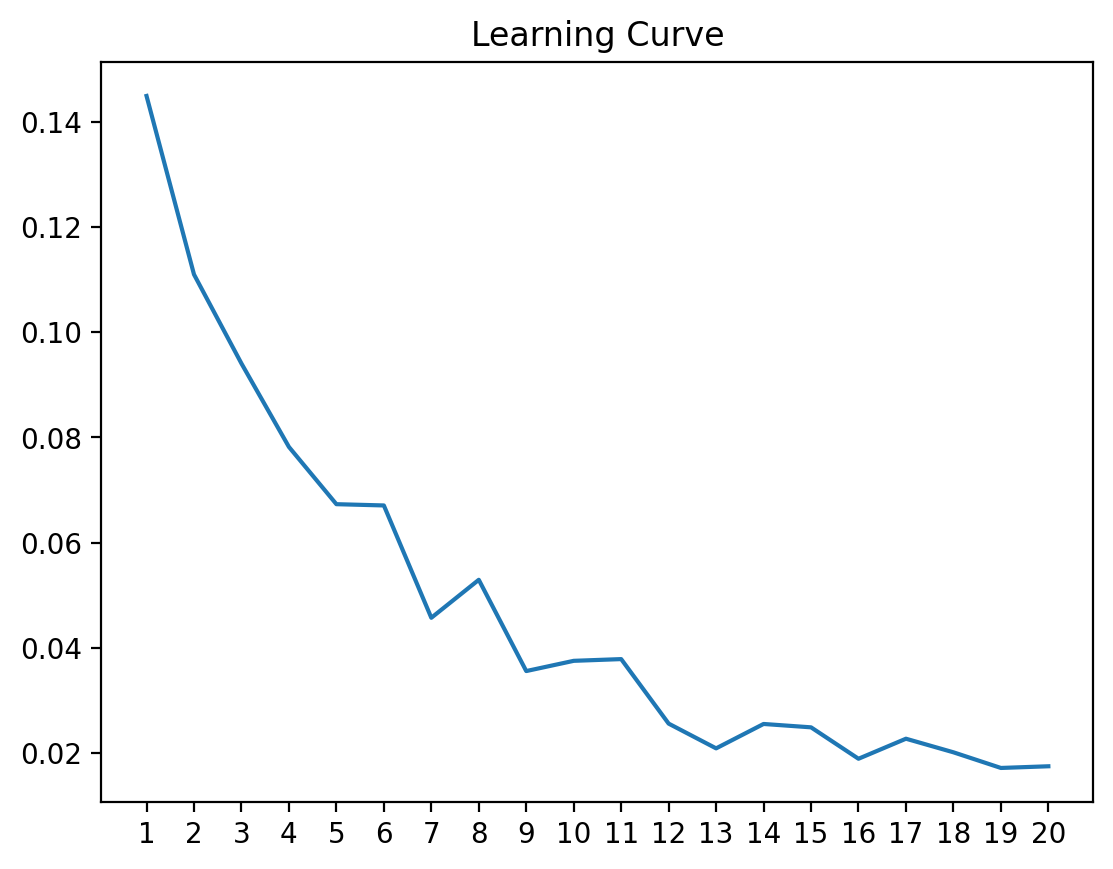

In [115]:


learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [116]:
train_paired_caped_result = model.evaluate(train_paired_caped)

# print('loss:', train_paired_caped_result[0], 'binary accuracy:', train_paired_caped_result[1])

val_paired_caped_result = model.evaluate(val_paired_caped)

# print('loss:', val_paired_caped_result[0], 'binary accuracy:', val_paired_caped_result[1])

test_paired_caped_result = model.evaluate(test_paired_caped)

# print('loss:', test_paired_caped_result[0], 'binary accuracy:', test_paired_caped_result[1])

106/106 [==============================] - 23s 219ms/step - loss: 0.0994 - binary_accuracy: 0.9746


# Final score prediction

## Creating Tensorflow Dataset (Single Image, Score Segment)

In [ ]:
import tensorflow as tf
import numpy as np

# See Python Generator
# https://peps.python.org/pep-0255/
def generator_score_single():
    metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
    
    for _, row in metadata.iterrows():
        image_a_path = 'fakenet_dataset/score/images/' + row['file_name_a']
        image_b_path = 'fakenet_dataset/score/images/' + row['file_name_b']

        image_a_np = np.array(Image.open(image_a_path))
        image_b_np = np.array(Image.open(image_b_path))

        model_input = image_a_np
        yield model_input

        # Uncomment if you want to compare the two images after inference
        # model_input = image_b_np
        # yield model_input


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_score_single() -> tf.data.Dataset:
    model_input = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    dataset_signature = model_input

    dataset = tf.data.Dataset.from_generator(
        generator_score_single, 
        output_signature=dataset_signature
    )

    return dataset

In [ ]:
# score_single_dataset = build_dataset_score_single().batch(16)
# model_input = next(iter(score_single_dataset))
# display(model_input.shape)

## Creating Tensorflow Dataset (Paired Image, Score Segment)

In [31]:
# See Python Generator
# https://peps.python.org/pep-0255/
def generator_score_paired():
    metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')

    for _, row in metadata.iterrows():
        image_a_path = 'fakenet_dataset/score/images/' + row['file_name_a']
        image_b_path = 'fakenet_dataset/score/images/' + row['file_name_b']

        image_a_np = np.array(Image.open(image_a_path))
        image_b_np = np.array(Image.open(image_b_path))

        model_input = (image_a_np, image_b_np)
        yield (model_input,)


# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_score_paired():
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore

    model_input = (image_signature, image_signature)

    dataset_signature = (model_input,)

    dataset = tf.data.Dataset.from_generator(
        generator_score_paired, 
        output_signature=dataset_signature
    )

    return dataset

## Creating Tensorflow Dataset (Paired Caped Image, Score Segment)

In [77]:
# See Python Generator
# https://peps.python.org/pep-0255/
def build_generator_scored_paired_caped():
    metadata = pd.read_csv('fakenet_dataset/score/metadata.csv')
    def generator():
        for _, row in metadata.iterrows():
            image_a_path = 'fakenet_dataset/score/images/' + row['file_name_a']
            image_b_path = 'fakenet_dataset/score/images/' + row['file_name_b']

            image_a_np = np.array(Image.open(image_a_path))
            image_b_np = np.array(Image.open(image_b_path))
            
            # Get captions
            caption = tokenizer(
                            text=row['caption'],
                            add_special_tokens=True,
                            max_length=max_len,
                            truncation=True,
                            padding="max_length",
                            # return_tensors='tf',
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            verbose=False
                        )

            

            
            model_input = (image_a_np, image_b_np, caption['input_ids'], caption['attention_mask'])
            

            yield (model_input, )

    return generator

# See Tensorflow Dataset
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
def build_dataset_scored_paired_caped():
    image_signature = tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)  # type: ignore
    token_signature = tf.TensorSpec(shape=(max_len,), dtype=tf.int32) # caption signature

    model_input = (image_signature, image_signature, token_signature, token_signature)
    

    dataset_signature = (model_input,)

    dataset = tf.data.Dataset.from_generator(
        build_generator_scored_paired_caped(), 
        output_signature=dataset_signature
    )

    return dataset

In [32]:
# score_paired_dataset = build_dataset_score_paired().batch(16)

# ((model_input_a, model_input_b),) = next(iter(score_paired_dataset))

# display(model_input_a.shape, model_input_b.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

In [78]:
score_paired_caped_dataset = build_dataset_scored_paired_caped().batch(16)

((model_input_a, model_input_b, caption_input_ids, caption_masks),) = next(iter(score_paired_caped_dataset))

display(model_input_a.shape, model_input_b.shape, caption_input_ids.shape, caption_masks.shape)

TensorShape([16, 224, 224, 3])

TensorShape([16, 224, 224, 3])

TensorShape([16, 50])

TensorShape([16, 50])

## Prediction

In [117]:
# score_y_hat = model.predict(score_single_dataset)

score_y_hat = model.predict(score_paired_caped_dataset)

In [118]:
# The expected model output for the score segment is a DataFrame with 1 column -- 'probability'.
# One probability per row in the score metadata.
# The probability represents the likelihood that the image in the 'file_name_a' column is real.

# The following code can be used to check the DataFrame in 'score_y_hat':

score_y_hat = pd.DataFrame(score_y_hat, columns=['probability'])
assert score_y_hat.shape == (score_metadata.shape[0], 1)
assert score_y_hat.probability.dtype == np.float32
assert score_y_hat.probability.min() >= 0
assert score_y_hat.probability.max() <= 1

In [119]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. the probabilities for the score segment

import os
model_dir = 'fakenet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')